In [103]:
import numpy as np
import pandas as pd
import geopandas as gp

from sklearn import linear_model
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

# Load the json file with county coordinates
geoData = gp.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

# Make sure the "id" column is an integer
geoData.id = geoData.id.astype(str).astype(int)

# Remove Alaska, Hawaii and Puerto Rico.
stateToRemove = ['02', '15', '72']
geoData = geoData[~geoData.STATE.isin(stateToRemove)]

In [108]:
df = pd.read_csv('./US_MaizeYield+Predictors_1950-2013.csv')
df['fips'] = df['fips'].astype(str).astype(int)

# drop counties with less than 30 obs
good_counties = df.groupby('fips').count()['yield'] >= 30 
df = df.set_index('fips')
df = df.loc[good_counties]
df = df.sort_values(by = ['fips', 'year'])

In [139]:
df.columns

Index(['yield', 'year', 'state', 'area', 'EDD_4', 'GDD_4', 'prcp_4',
       'SM_mean_4', 'SM_week_max_4', 'SM_week_min_4', 'SM_mean2_4', 'prcp2_4',
       'EDD_5', 'GDD_5', 'prcp_5', 'SM_mean_5', 'SM_week_max_5',
       'SM_week_min_5', 'SM_mean2_5', 'prcp2_5', 'EDD_6', 'GDD_6', 'prcp_6',
       'SM_mean_6', 'SM_week_max_6', 'SM_week_min_6', 'SM_mean2_6', 'prcp2_6',
       'EDD_7', 'GDD_7', 'prcp_7', 'SM_mean_7', 'SM_week_max_7',
       'SM_week_min_7', 'SM_mean2_7', 'prcp2_7', 'EDD_8', 'GDD_8', 'prcp_8',
       'SM_mean_8', 'SM_week_max_8', 'SM_week_min_8', 'SM_mean2_8', 'prcp2_8',
       'EDD_9', 'GDD_9', 'prcp_9', 'SM_mean_9', 'SM_week_max_9',
       'SM_week_min_9', 'SM_mean2_9', 'prcp2_9', 'maize_irr_frac'],
      dtype='object')

In [140]:
# Choose subset of predictors
predictors = ['year', 
              'GDD_4', 'GDD_5', 'GDD_6', 'GDD_7', 'GDD_8', 'GDD_9', 
              'EDD_4', 'EDD_5', 'EDD_6', 'EDD_7', 'EDD_8', 'EDD_9',
              'prcp_4', 'prcp_5', 'prcp_6', 'prcp_7', 'prcp_8', 'prcp_9',
              'prcp2_4', 'prcp2_5', 'prcp2_6', 'prcp2_7', 'prcp2_8', 'prcp2_9',
              'maize_irr_frac']

In [144]:
results_reg = {}
results_r2 = {}

for fips in df.index.unique():
    X = df.loc[fips][predictors].to_numpy()
    y = df.loc[fips]['yield'].to_numpy()
    
    if len(y) > 30:
        reg = linear_model.LinearRegression()
        reg.fit(X, y)
        results_reg.update({fips : reg})
        results_r2.update({fips : r2_score(y, reg.predict(X))})

In [165]:
def plot_linreg(fips):
    fig, ax = plt.subplots(figsize = (10,5))
    
    # Predictions
    X = df.loc[fips][predictors].to_numpy()
    ax.plot(X[:,0], results_reg[fips].predict(X), label='Predictions')
    
    # Observations
    y = df.loc[fips]['yield'].to_numpy()
    ax.plot(X[:,0], y, 'ro', label='Observations')
    
    ax.set_ylabel('Yield')
    ax.set_xlabel('Year')
    plt.legend()
    plt.show()

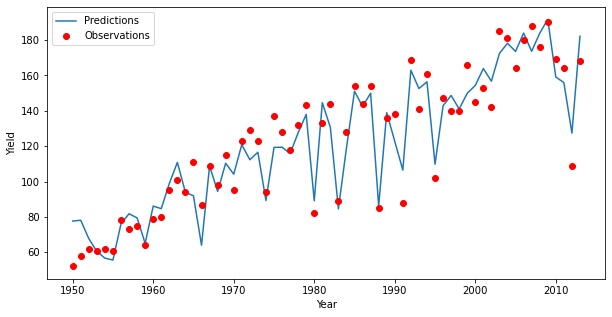

In [166]:
plot_linreg(17019) # Champaign county

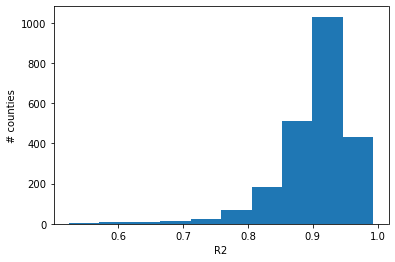

In [158]:
# Plot histogram of R2
fig, ax = plt.subplots()

ax.hist(results_r2.values())
ax.set_xlabel('R2')
ax.set_ylabel('# counties')

plt.show()

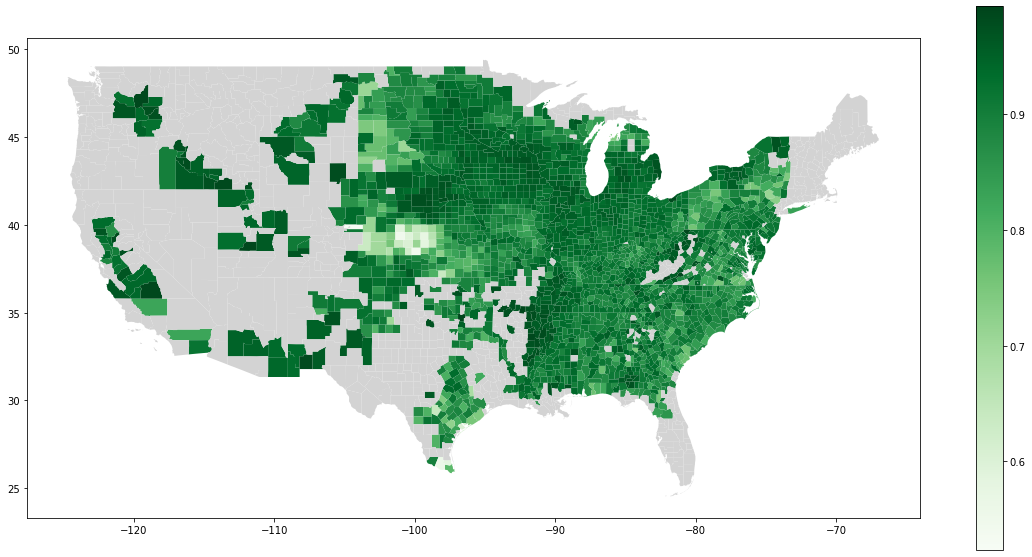

In [156]:
# Merge to plot
df_results = pd.DataFrame.from_dict(results_r2, orient='index', columns = ['R2']).reset_index()
df_results = pd.merge(geoData, df_results, right_on = 'index', left_on = 'id', how='outer')

# Plot R2
fig, ax = plt.subplots(figsize=(20,10))

df_results.plot(column = 'R2', ax=ax, legend=True, cmap = 'Greens', missing_kwds={'color': 'lightgrey'})

plt.show()